In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model, metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

np.random.seed(0)

In [3]:
# converts dataframe into numpy array of correct shape
def convert(df: pd.DataFrame, frame_size=10):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
    return x

In [4]:
######################## Load Model from .joblib file ####
from joblib import dump,load
reg = load('flowSenseRegressor.joblib')

/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DummyRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 0.24.2 when using version 1.0.1. This might 

In [38]:
######################## Load Datasets ####

data_dir = Path("../../Datasets/Smartphone/50cm")
df1 = pd.read_csv(data_dir / "VentOne_0degrees_50cm.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()
df1 = convert(df1)

df2 = pd.read_csv(data_dir / "VentOne_180degrees_50cm.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()
df2 = convert(df2)

df3 = pd.read_csv(data_dir / "VentOne_90degrees_50cm.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3.dropna()
df3 = convert(df3)


data_dir = Path("../../Datasets/Smartphone/1m")
df4 = pd.read_csv(data_dir / "VentOne_0degrees_1meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4.dropna()
df4 = convert(df4)

df5 = pd.read_csv(data_dir / "VentOne_180degrees_1meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5.dropna()
df5 = convert(df5)

df6 = pd.read_csv(data_dir / "VentOne_90degrees_1meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df6 = df6[df6['frequency'] != "clocktime"]
df6 = df6.dropna()
df6 = convert(df6)


data_dir = Path("../../Datasets/Smartphone/1.5m")
df7 = pd.read_csv(data_dir / "VentOne_0degrees_1-5meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df7 = df7[df7['frequency'] != "clocktime"]
df7 = df7.dropna()
df7 = convert(df7)

df8 = pd.read_csv(data_dir / "VentOne_90degrees_1-5meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df8 = df8[df8['frequency'] != "clocktime"]
df8 = df8.dropna()
df8 = convert(df8)

df9 = pd.read_csv(data_dir / "VentOne_180degrees_1-5meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df9 = df9[df9['frequency'] != "clocktime"]
df9 = df9.dropna()
df9 = convert(df9)


data_dir = Path("../../Datasets/Smartphone/SideVent")
df10 = pd.read_csv(data_dir / "SideVent_0degrees_0cm.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df10 = df10[df10['frequency'] != "clocktime"]
df10 = df10.dropna()
df10 = convert(df10)


data_dir = Path("../../Datasets/Smartphone/2.25m")
df11 = pd.read_csv(data_dir / "VentOne_0degrees_2-25meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df11 = df11[df11['frequency'] != "clocktime"]
df11 = df11.dropna()
df11 = convert(df11)

df12 = pd.read_csv(data_dir / "VentTwo_90degrees_2-25meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df12 = df12[df12['frequency'] != "clocktime"]
df12 = df12.dropna()
df12 = convert(df12)

df13 = pd.read_csv(data_dir / "VentOne_180degrees_2-25meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df13 = df13[df13['frequency'] != "clocktime"]
df13 = df13.dropna()
df13 = convert(df13)

df14 = pd.read_csv(data_dir / "VentOne_0degrees_2-25meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df14 = df14[df14['frequency'] != "clocktime"]
df14 = df14.dropna()
df14 = convert(df14)

def indices(df):
    indices = np.random.choice(df.shape[0], size=3000, replace=False, p=None)
    return df[indices, :]

def indicesSmaller(df):
    indices = np.random.choice(df.shape[0], size=400, replace=False, p=None)
    return df[indices, :]

sf1 = indices(df1)
sf2 = indices(df2)
sf3 = indices(df3)
sf4 = indices(df4)
sf5 = indices(df5)
sf6 = indices(df6)
sf7 = indices(df7)
sf8 = indices(df8)
sf9 = indices(df9)
sf10 = indices(df10)
sf11 = indicesSmaller(df11)
sf12 = indicesSmaller(df12)
sf13 = indicesSmaller(df13)
sf14 = indicesSmaller(df14)

In [ ]:
MSE_scores05 = []
MSE_scores10 = []
MSE_scores15 = []
MSE_scores22 = []

Mean Squared Error:  1.998788509502003


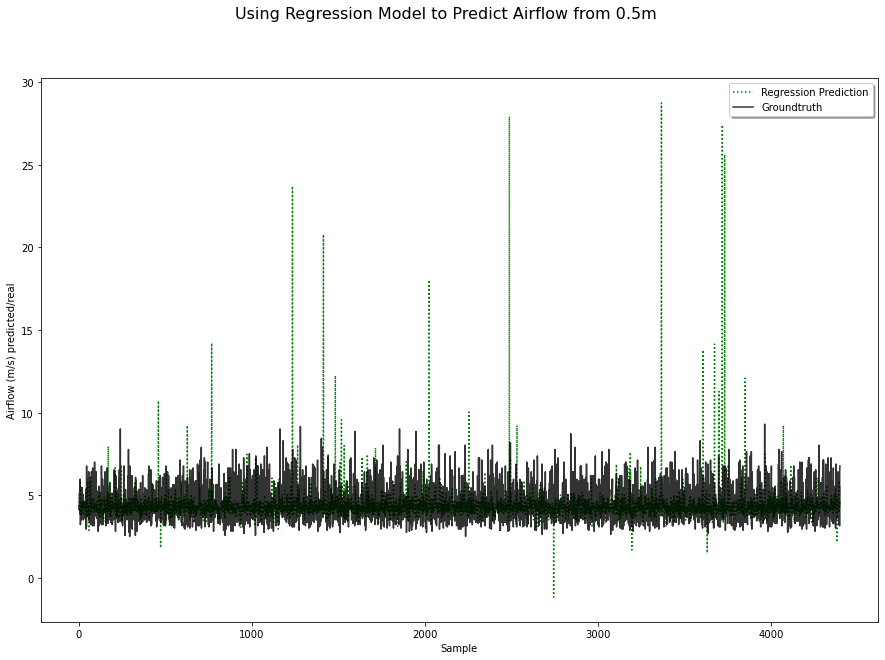

Mean Squared Error:  0.8286005944138879
Mean Squared Error:  1.7609401731687069
Mean Squared Error:  0.9592398978110995
Mean Squared Error:  1.4350991353992006
Mean Squared Error:  1.320224758239699
[0.8286005944138879, 1.7609401731687069, 0.9592398978110995, 1.4350991353992006, 1.320224758239699]


In [40]:
############# Looking at Naive predictions from 0.5m
data_dir = Path("../../Datasets/Smartphone/50cm")
df1 = pd.read_csv(data_dir / "VentOne_0degrees_50cm.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()
df1 = convert(df1)

df2 = pd.read_csv(data_dir / "VentOne_180degrees_50cm.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()
df2 = convert(df2)

df3 = pd.read_csv(data_dir / "VentOne_90degrees_50cm.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3.dropna()
df3 = convert(df3)

# assign desired dataset to df.
# default behavior tests on 90 degree orientation dataset.
df = df3

indices = np.random.choice(np.arange(df.shape[0]), size=4400, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model to Predict Airflow from 0.5m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.8)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(4400), range(4400,8800), range(8800,13200), range(13200, 17600), range(17600, 22000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores05.append(mean_squared_error(reg.predict(X), y))

print(MSE_scores05)

Mean Squared Error:  1.3795536907876975


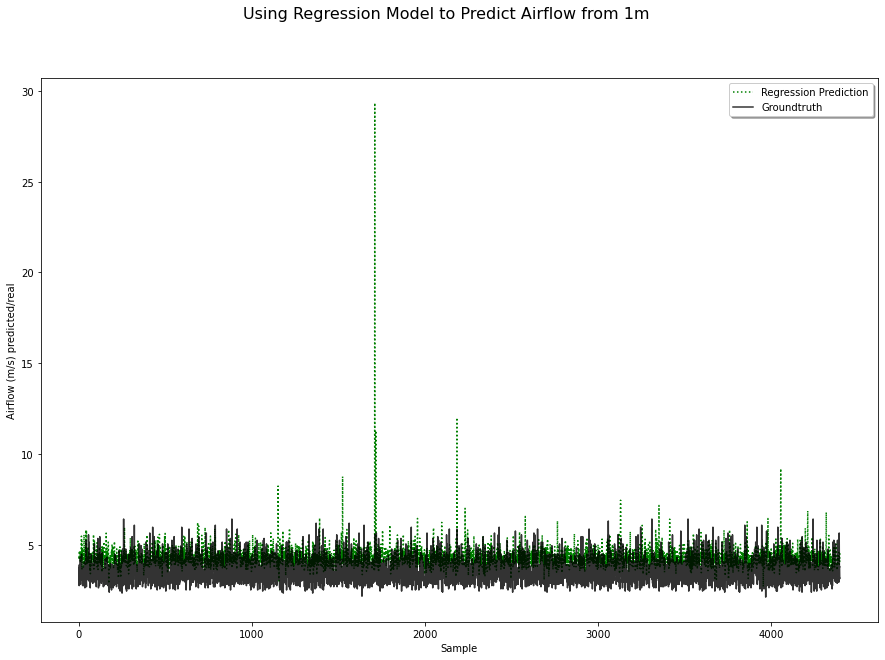

Mean Squared Error:  0.9418492722000267
Mean Squared Error:  3.526754876121136
Mean Squared Error:  0.8095607162256863
Mean Squared Error:  0.8909564139791244
Mean Squared Error:  1.141663541620025
[0.9418492722000267, 3.526754876121136, 0.8095607162256863, 0.8909564139791244, 1.141663541620025]


In [41]:
############# Looking at Naive predictions from 1m
data_dir = Path("../../Datasets/Smartphone/1m")
df4 = pd.read_csv(data_dir / "VentOne_0degrees_1meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4.dropna()
df4 = convert(df4)

df5 = pd.read_csv(data_dir / "VentOne_180degrees_1meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5.dropna()
df5 = convert(df5)

df6 = pd.read_csv(data_dir / "VentOne_90degrees_1meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df6 = df6[df6['frequency'] != "clocktime"]
df6 = df6.dropna()
df6 = convert(df6)

# assign desired dataset to df.
# default behavior tests on 180 degree orientation dataset.
df = df5

indices = np.random.choice(np.arange(df.shape[0]), size=4400, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model to Predict Airflow from 1m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha = 0.8)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(4400), range(4400,8800), range(8800,13200), range(13200, 17600), range(17600, 22000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores10.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores10)

Mean Squared Error:  2.4508923804411062


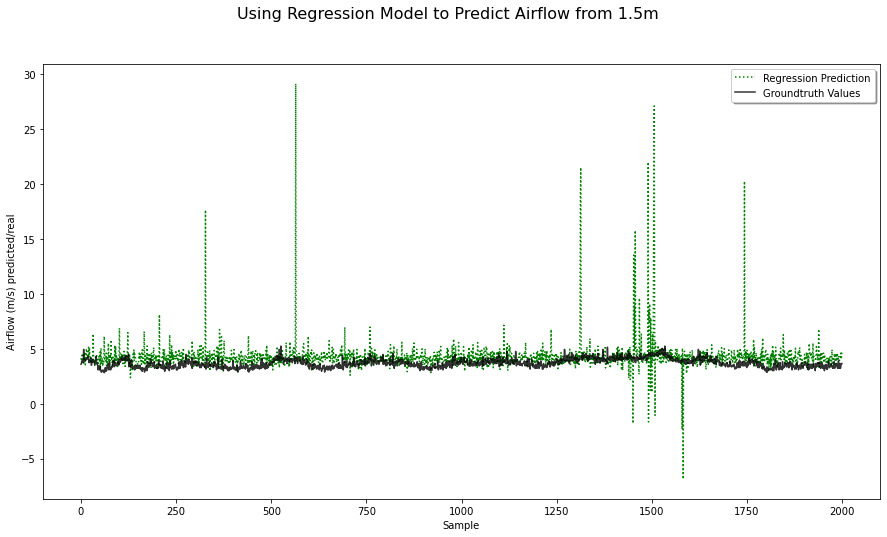

Mean Squared Error:  2.4508923804411062
Mean Squared Error:  0.9892761656931198
Mean Squared Error:  0.5771994304484952
Mean Squared Error:  0.7476441510295138
Mean Squared Error:  0.9917212490994095
[2.4508923804411062, 0.9892761656931198, 0.5771994304484952, 0.7476441510295138, 0.9917212490994095]


In [42]:
############# Looking at Naive predictions from 1.5m
data_dir = Path("../../Datasets/Smartphone/1.5m")
df7 = pd.read_csv(data_dir / "VentOne_0degrees_1-5meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df7 = df7[df7['frequency'] != "clocktime"]
df7 = df7.dropna()
df7 = convert(df7)

df8 = pd.read_csv(data_dir / "VentOne_90degrees_1-5meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df8 = df8[df8['frequency'] != "clocktime"]
df8 = df8.dropna()
df8 = convert(df8)

df9 = pd.read_csv(data_dir / "VentOne_180degrees_1-5meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df9 = df9[df9['frequency'] != "clocktime"]
df9 = df9.dropna()
df9 = convert(df9)

# assign desired dataset to df.
# default behavior tests on 180 degree orientation dataset.
df = df9

indices = range(2000)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(8)
fig1.suptitle('Using Regression Model to Predict Airflow from 1.5m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.8)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth Values'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(2000), range(2000,4000), range(4000,6000), range(6000,7000), range(7000,8000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores15.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores15)

Mean Squared Error:  1.4082740250043417


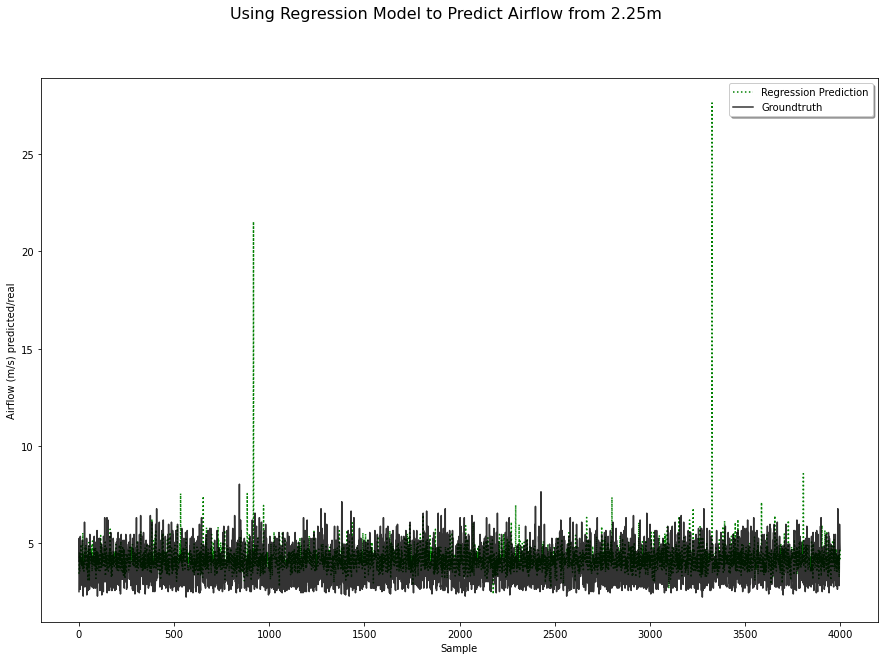

Mean Squared Error:  1.2015819106177645


NameError: name 'MSE_scores22' is not defined

In [6]:
############# Looking at Naive predictions from 2.25m
data_dir = Path("../../Datasets/Smartphone/2.25m")
df11 = pd.read_csv(data_dir / "VentOne_0degrees_2-25meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df11 = df11[df11['frequency'] != "clocktime"]
df11 = df11.dropna()
df11 = convert(df11)

df13 = pd.read_csv(data_dir / "VentOne_180degrees_2-25meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df13 = df13[df13['frequency'] != "clocktime"]
df13 = df13.dropna()
df13 = convert(df13)

df14 = pd.read_csv(data_dir / "VentOne_90degrees_2-25meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df14 = df14[df14['frequency'] != "clocktime"]
df14 = df14.dropna()
df14 = convert(df14)

# assign desired dataset to df.
# default behavior tests on 0 degree orientation dataset.
df = df11

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)

X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape

print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model to Predict Airflow from 2.25m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.8)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(2000,4000), range(4000,6000), range(6000,7000), range(7000,8000), range(8000,10000)]:
    X = df[:,:-1]
    X = X[indices, :6]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores22.append(mean_squared_error(reg.predict(X), y))

print(MSE_scores22)

Mean Squared Error:  5.696819425766616


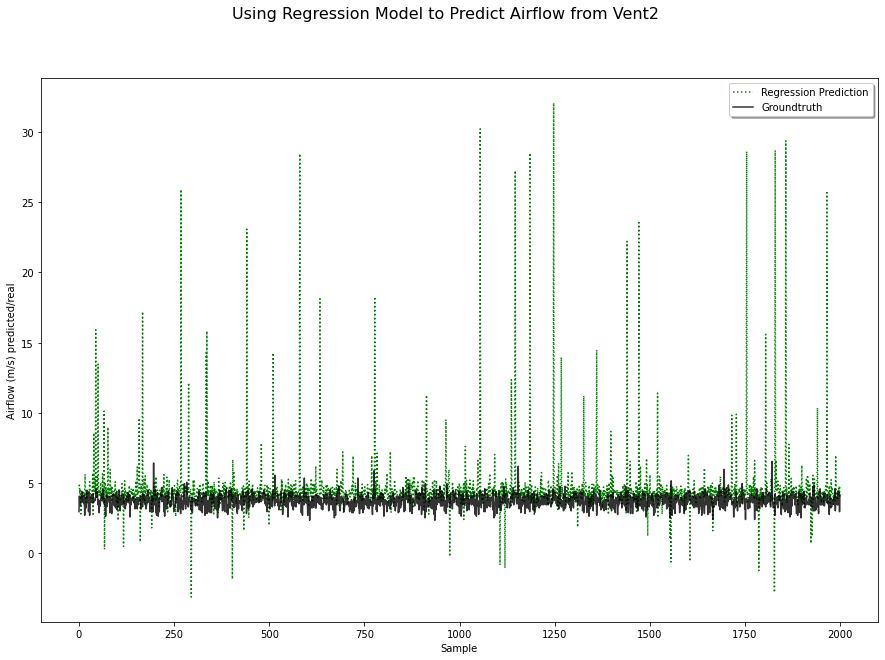

In [44]:
############# Looking at Naive predictions from Vent Two Data, 1m or 2.25m
data_dir = Path("../../Datasets/Smartphone/1m")
df15 = pd.read_csv(data_dir / "VentTwo_0degrees_1meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df15 = df15[df15['frequency'] != "clocktime"]
df15 = df15.dropna()
df15 = convert(df15)

data_dir = Path("../../Datasets/Smartphone/2.25m")
df12 = pd.read_csv(data_dir / "VentTwo_90degrees_2-25meters.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df12 = df12[df12['frequency'] != "clocktime"]
df12 = df12.dropna()
df12 = convert(df12)

# assign desired dataset to df.
# default behavior tests on 1m dataset from Vent Two
df = df15

indices = np.random.choice(np.arange(df.shape[0]), size=2000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model to Predict Airflow from Vent2', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.8)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

Mean Squared Error:  5.984289020176286


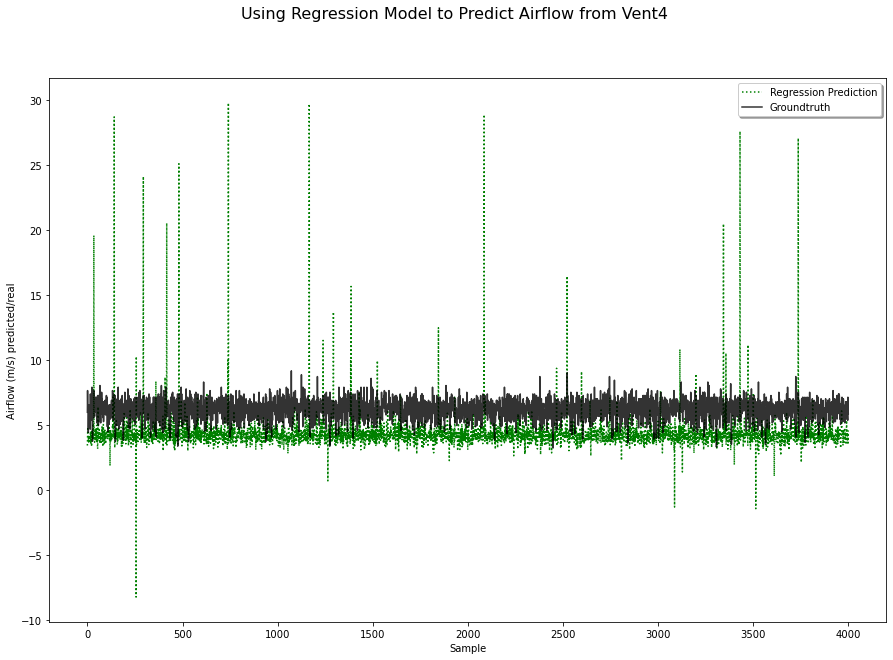

In [48]:
############# Looking at Naive predictions from Vent Four Data
data_dir = Path("../../Datasets/Smartphone/1m")
df16 = pd.read_csv(data_dir / "VentFour_0degrees_1meter.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df16 = df16[df16['frequency'] != "clocktime"]
df16 = df16.dropna()
df16 = convert(df16)

df = df16

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :6]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Regression Model to Predict Airflow from Vent4', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-', alpha=0.8)
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

In [ ]:
######################## IMPLEMENT PERSISTENT MINIMUM SCHEME AND TEST ON SMALL SUBSET ####

def avg(lst):
    return sum(lst) / len(lst)

def getPersistentMinimum(inp, num=5, epsilon=0.5):
    window = [inp[0]]
    for i in range(1, len(inp)):
        if abs(inp[i] - avg(window)) > epsilon: #if this prediction deviates from the running mean by more than epsilon...
            window = [inp[i]]    #start over, reset our window size
        else:
            window.append(inp[i])
        if len(window) == int(num):
            return avg(window)
    return 0

# assign desired dataset to df.
# default behavior tests on two of the smaller datasets
df = np.concatenate([sf8, sf9], axis=0)

predictions = []
minimumPersistent = []
totalMinimum = []
groundtruths = []
tempPred = []
tempGround = []

for i in range(1, df.shape[0]):
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-1])
    if i % 15 == 0:
        tempPred.sort()
        perMin = getPersistentMinimum(tempPred)
        if (perMin != 0):
            minimumPersistent.append(perMin)
            totalMinimum.append(tempPred[0])
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(8)
fig1.suptitle('Minimum Persistent method on test data', fontsize=16)
l1, = ax1.plot(groundtruths, 'k--', alpha = 1)
l0, = ax1.plot(predictions, 'g--', alpha = 0.5)
l2, = ax1.plot(minimumPersistent, 'b-', alpha = 0.8)
ax1.legend((l0, l2, l1), ('Naive Prediction', 'Minimum-Persistent Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

print("MSE: ", mean_squared_error(minimumPersistent, groundtruths))

In [56]:
######################## TEST CANDIDATE PARAMETERS FOR PERSISTENT MINIMUM SCHEME ####
def avg(lst):
    return sum(lst) / len(lst)

def getPersistentMinimum(inp, num=5, epsilon=0.5):
    window = [inp[0]]
    for i in range(1, len(inp)):
        if abs(inp[i] - avg(window)) > epsilon: #if this prediction deviates from the running mean by more than epsilon...
            window = [inp[i]]    #start over, reset our window size
        else:
            window.append(inp[i])
        if len(window) == int(num):
            return avg(window)
    return 0

# assign desired dataset to df.
# default behavior tests on 2.25m, 180 degree orientation dataset.
df = df13

def justMPS(s, n, e, range):
    predictions = []
    minimumPersistent = []
    groundtruths = []
    tempPred = []
    tempGround = []

    for i in range:
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-1])
        if i % s == 0:
            tempPred.sort()
            minimumPersistent.append(getPersistentMinimum(tempPred, num = n, epsilon = e))
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []
    print("Num Samples: {}, Window Size: {}, epsilon: {}".format(s,n,e))
    print("Naive MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    print("Just MinimumPersistent MSE: {}".format(mean_squared_error(minimumPersistent, groundtruths)))

samples = 25
n = 5
e = 0.5

# try different subranges of the dataset
justMPS(samples, n, e, range(1000,2000))
justMPS(samples, n, e, range(2000,3000))
justMPS(samples, n, e, range(3000,4000))
justMPS(samples, n, e, range(4000,5000))
justMPS(samples, n, e, range(5000,6000))
# justMPS(samples, n, e, range(7000,8000))
# justMPS(samples, n, e, range(8000,9000))
# justMPS(samples, n, e, range(9000,10000))
# justMPS(samples, n, e, range(10000,11000))
# justMPS(samples, n, e, range(11000,12000))
# justMPS(samples, n, e, range(12000,13000))

Num Samples: 25, Window Size: 5, epsilon: 0.5
Naive MSE: 0.4891505067327702
Just MinimumPersistent MSE: 0.3688364582378056
Num Samples: 25, Window Size: 5, epsilon: 0.5
Naive MSE: 0.8727575566431158
Just MinimumPersistent MSE: 0.3978658773742591
Num Samples: 25, Window Size: 5, epsilon: 0.5
Naive MSE: 2.2982966939843608
Just MinimumPersistent MSE: 1.3679153516800615
Num Samples: 25, Window Size: 5, epsilon: 0.5
Naive MSE: 1.0556390640475464
Just MinimumPersistent MSE: 0.8346708698217252
Num Samples: 25, Window Size: 5, epsilon: 0.5
Naive MSE: 1.9553915320753816
Just MinimumPersistent MSE: 0.5463244761282986


/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-o